**Nama : Geraldus Jeremy Chandra**

**NIM : 2702368236**

**TUJUAN**

Pada soal nomor 2, kita membuat image data dengan memberikan noise nilai acak yang diambil dari distribusi normal (Gaussian), menggunakan rata-rata 0.0 dan standard deviasi 0.1. lalu tujuannya adalah untuk mengevaluasi nilai SSIM pada 3 model yang dibandingkan, yaitu model baseline, mmodified manual, dan modified dengan tuning.

In [ ]:
!unzip A_23-20250626T100121Z-1-001.zip

Archive:  A_23-20250626T100121Z-1-001.zip
  inflating: A_23/siirt 9.jpg        
  inflating: A_23/siirt 90.jpg       
  inflating: A_23/siirt 96.jpg       
  inflating: A_23/siirt 80.jpg       
  inflating: A_23/siirt 87.jpg       
  inflating: A_23/siirt 76.jpg       
  inflating: A_23/siirt 74.jpg       
  inflating: A_23/siirt 86.jpg       
  inflating: A_23/siirt 95.jpg       
  inflating: A_23/siirt 81.jpg       
  inflating: A_23/siirt 93.jpg       
  inflating: A_23/siirt 89.jpg       
  inflating: A_23/siirt 94.jpg       
  inflating: A_23/siirt 77.jpg       
  inflating: A_23/siirt 85.jpg       
  inflating: A_23/siirt 75.jpg       
  inflating: A_23/siirt 82.jpg       
  inflating: A_23/siirt 91.jpg       
  inflating: A_23/siirt 84.jpg       
  inflating: A_23/siirt 99.jpg       
  inflating: A_23/siirt 83.jpg       
  inflating: A_23/siirt 92.jpg       
  inflating: A_23/siirt 98.jpg       
  inflating: A_23/siirt 8.jpg        
  inflating: A_23/siirt 79.jpg       
  inflat

In [ ]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import keras_tuner as kt

**EDA**

In [ ]:
folder_path = '/content/A_23/'
image_files = [f for f in os.listdir(folder_path)]

In [ ]:
len(image_files)

1074

checking jumlah data

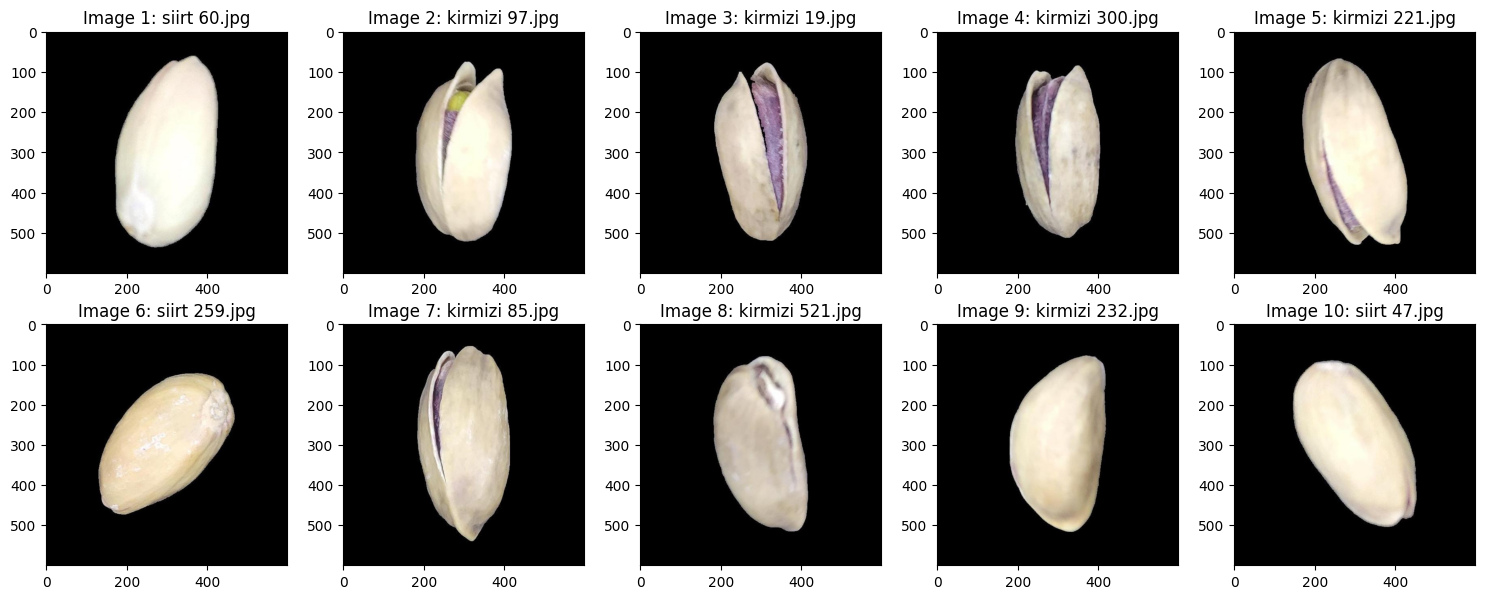

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

axes_flat = axes.flatten()

for i in range(10):
    ax = axes_flat[i]

    img_path = os.path.join(folder_path, image_files[i])

    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax.imshow(img_rgb)
    ax.set_title(f'Image {i+1}: {image_files[i]}')
plt.tight_layout()

checking visual

In [ ]:
def summarize_image_dimensions(image_files, folder_path):
    unique_sizes = set()

    for image_file in image_files:
        img_path = os.path.join(folder_path, image_file)
        img = cv2.imread(img_path)

        if img is None:
            continue

        unique_sizes.add(img.shape)

    sorted_sizes = sorted(list(unique_sizes))

    if not sorted_sizes:
        print("-> Tidak ada gambar valid yang ditemukan.")
    else:
        for size in sorted_sizes:
            height, width, channels = size
            print(f'Dimensi: {width}x{height}, Channels: {channels}')

summarize_image_dimensions(image_files, folder_path)

Dimensi: 600x600, Channels: 3


checking dimensi dan jumlah channels yang ada, karena ada tiga kita dapat asumsikan sudah RGB

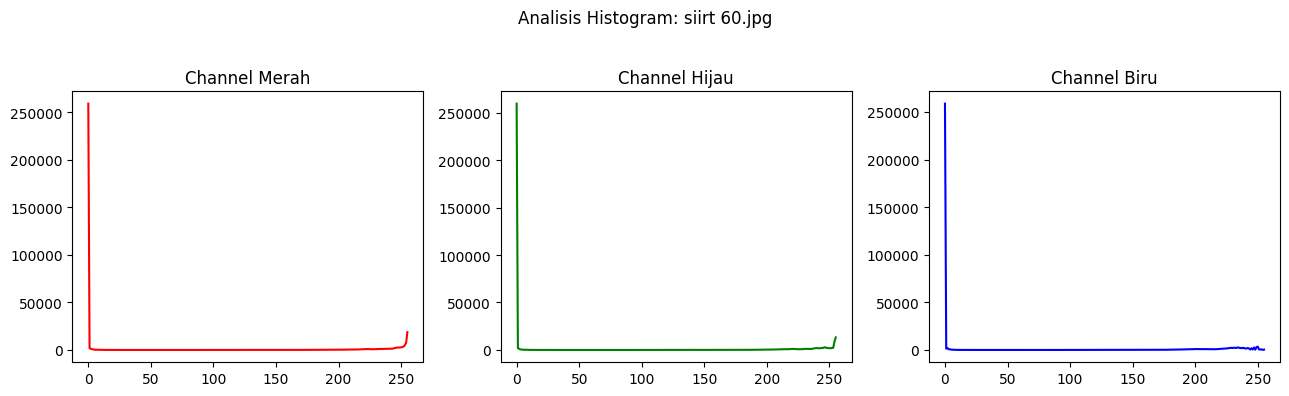

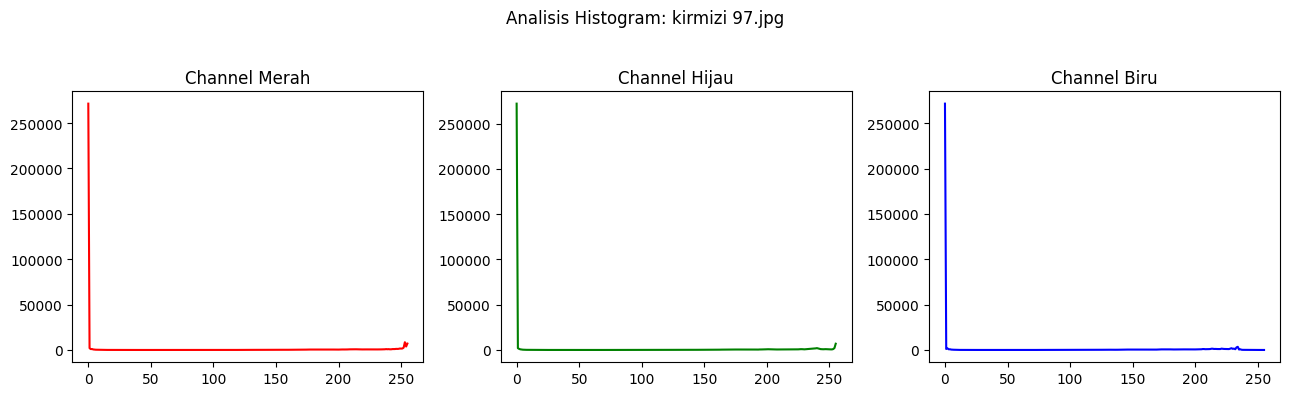

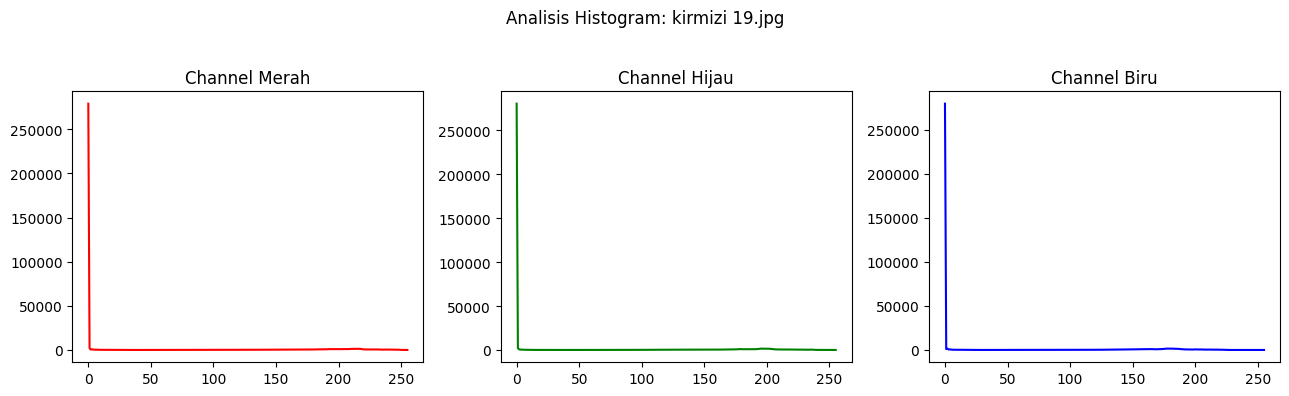

In [ ]:
for i in range(3):
    img_path = os.path.join(folder_path, image_files[i])
    img = cv2.imread(img_path)

    if img is None:
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    hist_red = cv2.calcHist([img_rgb], [0], None, [256], [0, 256])
    hist_green = cv2.calcHist([img_rgb], [1], None, [256], [0, 256])
    hist_blue = cv2.calcHist([img_rgb], [2], None, [256], [0, 256])

    plt.figure(figsize=(13, 4))
    plt.suptitle(f"Analisis Histogram: {image_files[i]}")

    plt.subplot(1, 3, 1)
    plt.plot(hist_red, color='red')
    plt.title("Channel Merah")

    plt.subplot(1, 3, 2)
    plt.plot(hist_green, color='green')
    plt.title("Channel Hijau")

    plt.subplot(1, 3, 3)
    plt.plot(hist_blue, color='blue')
    plt.title("Channel Biru")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

checking untuk analisis persebaran RGB nya, terlihat persebaran distribusi RGB untuk setiap gambar sama.

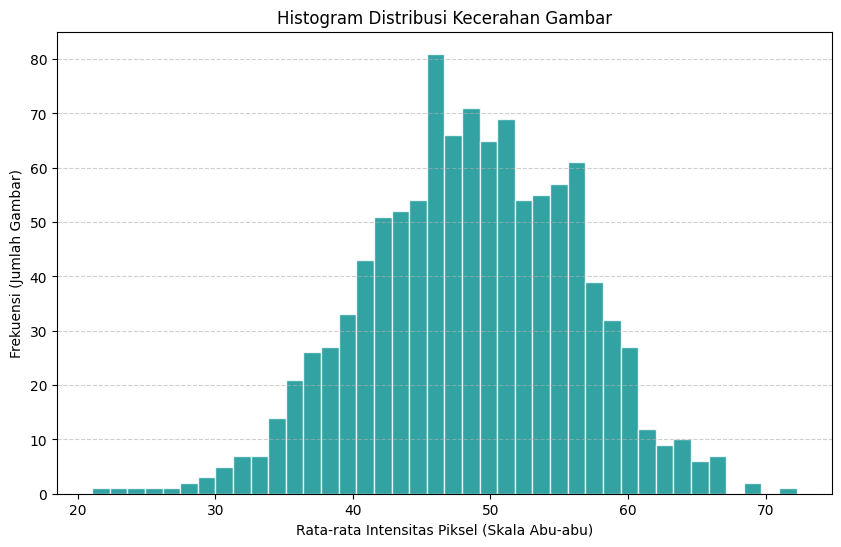

In [ ]:
def analyze_and_plot_lighting_distribution(image_files, folder_path):

    average_intensities = []
    for image_file in image_files:
        img_path = os.path.join(folder_path, image_file)
        img = cv2.imread(img_path)

        if img is None:
            continue

        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        average_intensities.append(np.mean(img_gray))

    if not average_intensities:
        print("Analisis dibatalkan: Tidak ada gambar valid yang ditemukan.")
        return

    plt.figure(figsize=(10, 6))

    plt.hist(average_intensities, bins=40, color='darkcyan', edgecolor='white', alpha=0.8)

    plt.title('Histogram Distribusi Kecerahan Gambar')
    plt.xlabel('Rata-rata Intensitas Piksel (Skala Abu-abu)')
    plt.ylabel('Frekuensi (Jumlah Gambar)')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

analyze_and_plot_lighting_distribution(image_files, folder_path)

distribusi pencahyaan dalam dataset ini bisa dilihat cukup seimbang dari segi persebarannnya, tidak terlalu gelap maupun terang.

**PREPROCESS**

In [ ]:
SEED_VALUE = 1234
np.random.seed(SEED_VALUE)

train_files, temp_files = train_test_split(image_files, test_size=0.2, random_state=SEED_VALUE)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=SEED_VALUE)

def load_and_preprocess_images(file_list, image_size=(100, 100)):
    images = []
    for file in file_list:
        img_path = os.path.join(folder_path, file)
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, image_size)
        images.append(img)

    images = np.array(images)
    return images

X_train = load_and_preprocess_images(train_files)
X_val = load_and_preprocess_images(val_files)
X_test = load_and_preprocess_images(test_files)

split data, lalu def function untuk mengambil daftar file, kemudian semua gambar dimuat ari disk dan mengubahnya menjadi ukuran 100x100 sesuai permintaan soal. warna dipastikan RGB, lalu function ini dipanggil untuk setiap set training, val dan testing menghasilkan 3 array yang isinya gambar yang sudah siap dimasukkan ke model

In [ ]:
X_train.shape

(859, 100, 100, 3)

In [ ]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

x_train_noisy = X_train + np.random.normal(loc=0.0, scale=0.1, size=X_train.shape)
x_val_noisy   = X_val   + np.random.normal(loc=0.0, scale=0.1, size=X_val.shape)
x_test_noisy  = X_test  + np.random.normal(loc=0.0, scale=0.1, size=X_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy   = np.clip(x_val_noisy, 0., 1.)
x_test_noisy  = np.clip(x_test_noisy, 0., 1.)

data dinormalize dan dibuat versi noisenya dari data tersebut. rangenya dari [0,255] menjadi [0,1] dan noise acak yang diambil dari distribusi gaussian sesuai ketentuan soal ditambahkan ke dataset bersih. np.clip untuk memastikan tidak ada nilai pixel yang berada di luar range.

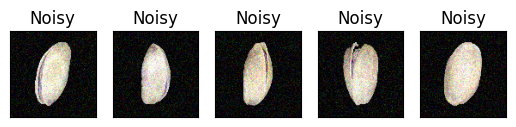

In [ ]:
for i in range(5):
  ax = plt.subplot(3, 5, i + 6)
  plt.imshow(x_train_noisy[i].reshape(100, 100, 3))
  plt.title("Noisy")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

**MODELLING**

In [ ]:
def build_autoencoder():
    input_img = layers.Input(shape=(100, 100, 3))

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

model conv autoencoder dengan keras functional API, encoder secara bertahap mengcompress input gambar melalui layer yang sudah diset, kemudian decoder mengconstruct ulang gambar ke ukuran aslinya menggunakan layer upsamping2d dan conv2d. output menggunakan activation sigmoid sesuai soal.

In [ ]:
history = autoencoder.fit(
    x_train_noisy,
    X_train,
    epochs=30,
    batch_size=32,
    shuffle=True,
    validation_data=(x_val_noisy, X_val)
)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 12/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0

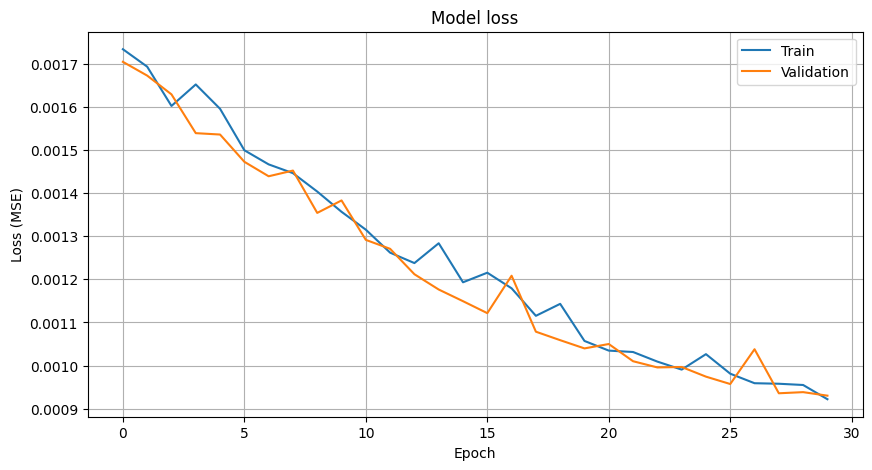

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

kedua saling menunjukan trend menurun walau sedikit naik turun. mengindikasikan kemungkinan model lebih sulit menemukan gradien yang konsisten. namun model bergerak berdekatan yang merupakan pertanda hasil yang tidak terlalu buruk untuk model baseline.

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step


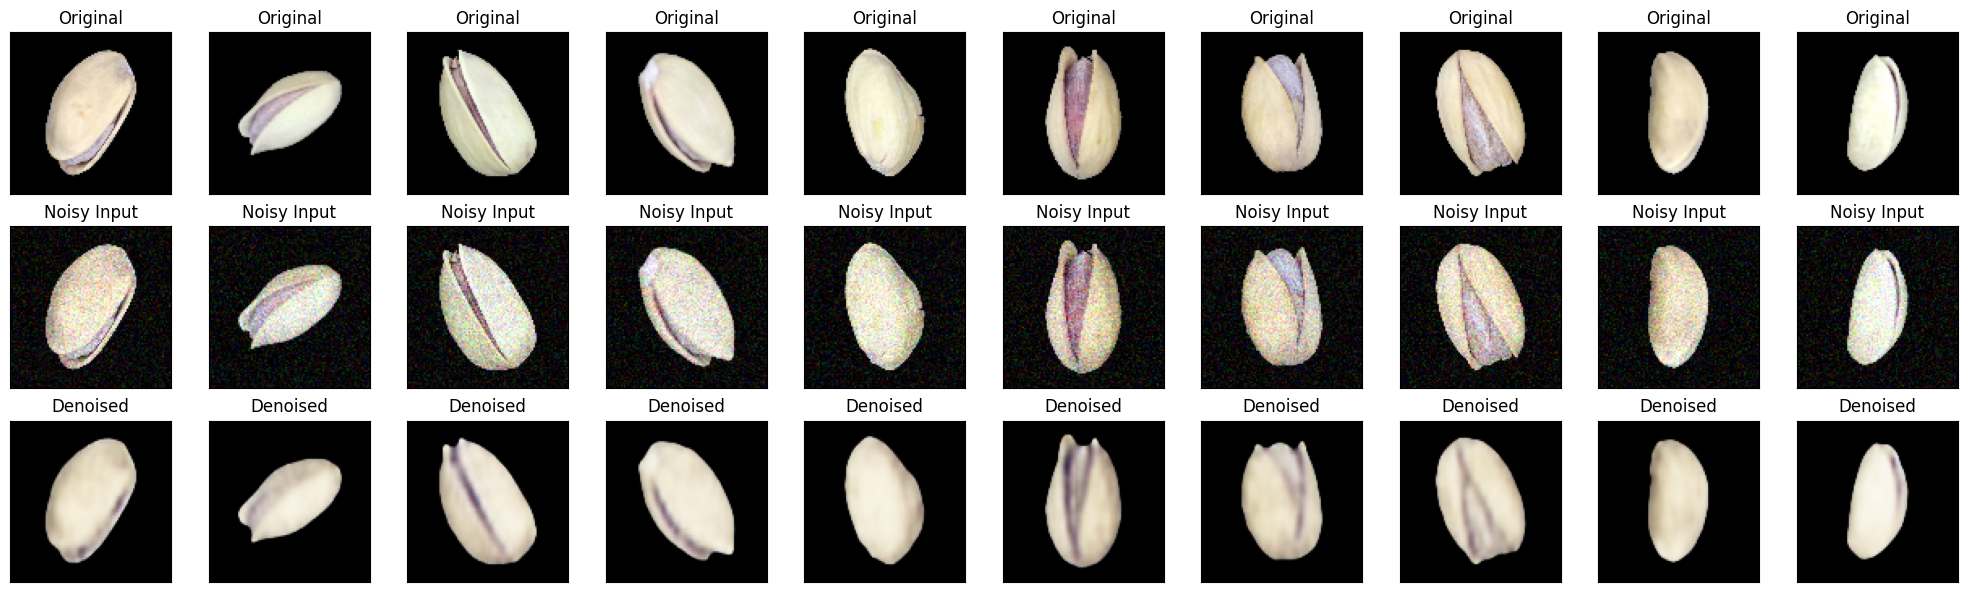

In [ ]:

denoised_images = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 6))

for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy Input")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_images[i])
    plt.title("Denoised")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
def build_manual_model():
    input_img = layers.Input(shape=(100, 100, 3))

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    manual_model = models.Model(input_img, decoded)
    manual_model.compile(optimizer='adam', loss='mse')
    return manual_model

manual_autoencoder = build_manual_model()
manual_autoencoder.summary()




Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 50, 50, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 50, 50, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 100, 100, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 100, 100, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 100, 100, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 741,379 (2.83 MB)

 Trainable params: 741,379 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

perbedaan dengan model sebelumnya adalah kapasitas dan kompleksitas arsitekturnya, jumlah filter layer conv2d di bagian encoder dan decoder telah ditingkatkan dengan tujuan agar modelnya bisa belajar lebih detail gambarnya dan reconstruct lebih akurat.

In [ ]:
history_manual = manual_autoencoder.fit(
    x_train_noisy,
    X_train,
    epochs=30,
    batch_size=32,
    shuffle=True,
    validation_data=(x_val_noisy, X_val)
)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 594ms/step - loss: 0.0932 - val_loss: 0.0041
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 12/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0

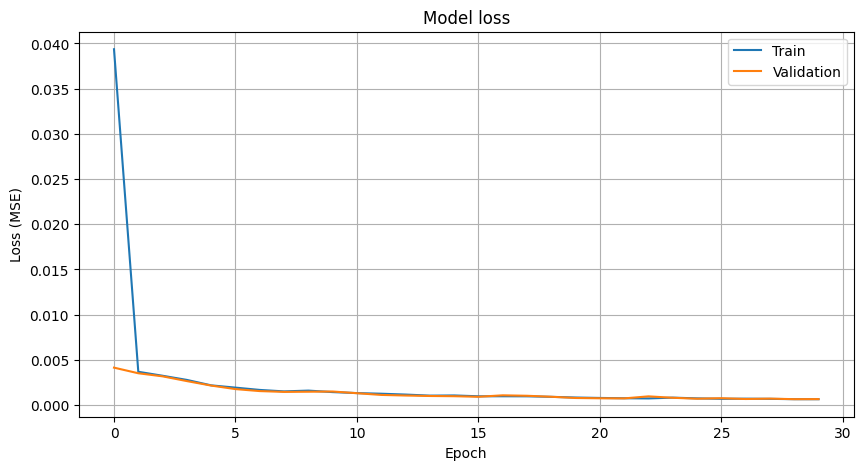

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_manual.history['loss'])
plt.plot(history_manual.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

hasil sangat baik, model terlihat belajar dengan kapasitas yang lebih besar dan garis sangat rapat pada nilai loss yang rendah, menunjukkan tidak adanya overfit, dan kemungkinan menghasil gambar yang baik

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


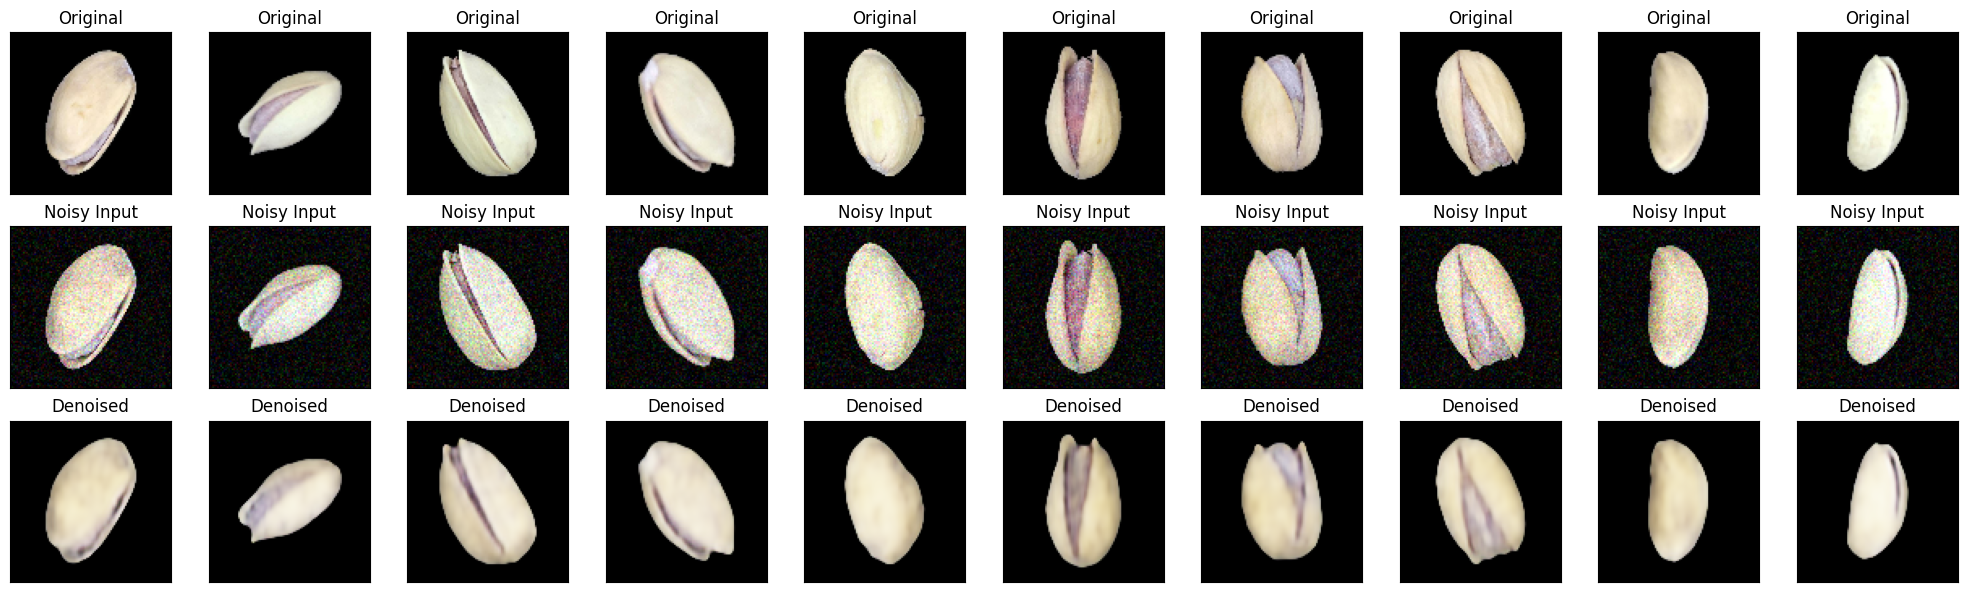

In [ ]:
denoised_images_manual = manual_autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 6))

for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy Input")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_images_manual[i])
    plt.title("Denoised")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
def build_tuner_model(hp):
    input_img = layers.Input(shape=(100, 100, 3))

    hp_filters_1 = hp.Int('filters_1', min_value=32, max_value=64, step=16)
    x = layers.Conv2D(hp_filters_1, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    hp_filters_2 = hp.Int('filters_2', min_value=64, max_value=128, step=32)
    x = layers.Conv2D(hp_filters_2, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(hp_filters_2, (3, 3), activation='relu', padding='same')(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(hp_filters_2, (3, 3), activation='relu', padding='same')(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(hp_filters_1, (3, 3), activation='relu', padding='same')(x)

    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model = models.Model(input_img, decoded)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mse')

    return model

disini function untuk hyper parameter tuning yang tujuannya menerima hasil komposisi terbaik dengan cara define parameter-parameter key nya lalu nanti akan dicari sekaligus dilatih.

In [ ]:
tuner = kt.Hyperband(build_tuner_model,
                     objective='val_loss',
                     max_epochs=15,
                     factor=3,
                     directory='keras_tuner_dir',
                     project_name='denoising_autoencoder')

tuner.search(x_train_noisy, X_train, epochs=15, validation_data=(x_val_noisy, X_val))

Trial 30 Complete [00h 00m 34s]
val_loss: 0.152704119682312

Best val_loss So Far: 0.0010324172908440232
Total elapsed time: 00h 10m 17s


In [ ]:
tuned_autoencoder = tuner.get_best_models(num_models=1)[0]
tuner.results_summary()

Results summary
Results in keras_tuner_dir/denoising_autoencoder
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0016 summary
Hyperparameters:
filters_1: 48
filters_2: 64
learning_rate: 0.001
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.0010324172908440232

Trial 0024 summary
Hyperparameters:
filters_1: 48
filters_2: 128
learning_rate: 0.001
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0019
Score: 0.0011630177032202482

Trial 0025 summary
Hyperparameters:
filters_1: 64
filters_2: 128
learning_rate: 0.001
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0023
Score: 0.0012445658212527633

Trial 0026 summary
Hyperparameters:
filters_1: 64
filters_2: 64
learning_rate: 0.001
tuner/epochs: 15
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.0012708279537037015

Trial 0017 summary
Hyperparameters:
filters_1: 64
filt

In [ ]:
history_tuned = tuned_autoencoder.fit(
    x_train_noisy,
    X_train,
    epochs=30,
    batch_size=32,
    shuffle=True,
    validation_data=(x_val_noisy, X_val)
)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0010 - val_loss: 9.8722e-04
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0010 - val_loss: 9.6049e-04
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 9.4752e-04 - val_loss: 9.2686e-04
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 9.6500e-04 - val_loss: 9.0130e-04
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 9.2970e-04 - val_loss: 9.3888e-04
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 9.2333e-04 - val_loss: 0.0011
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 9.5964e-04 - val_loss: 8.5323e-04
Epoch 12/30
27/27 

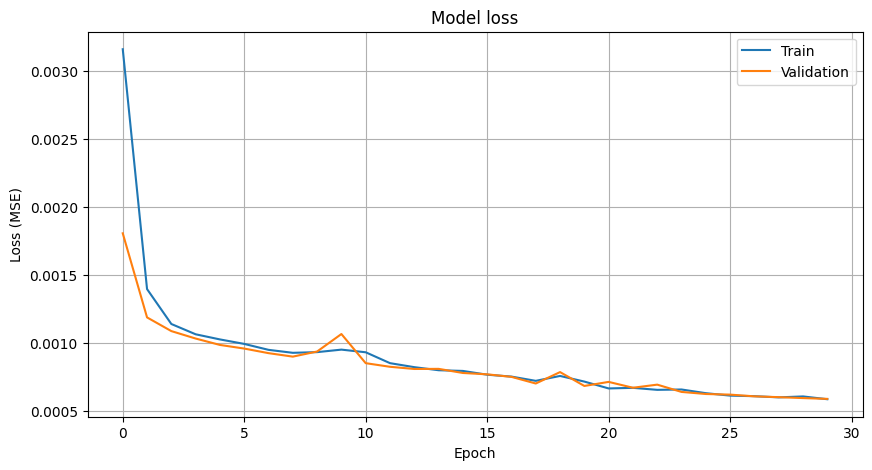

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_tuned.history['loss'])
plt.plot(history_tuned.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

hasilnya juga bagus, terlihat garis berada dekat satu sama lain dan tidak ada overfit yang berlebih hanya sedikit lonjakan di sekitar epoch 8

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


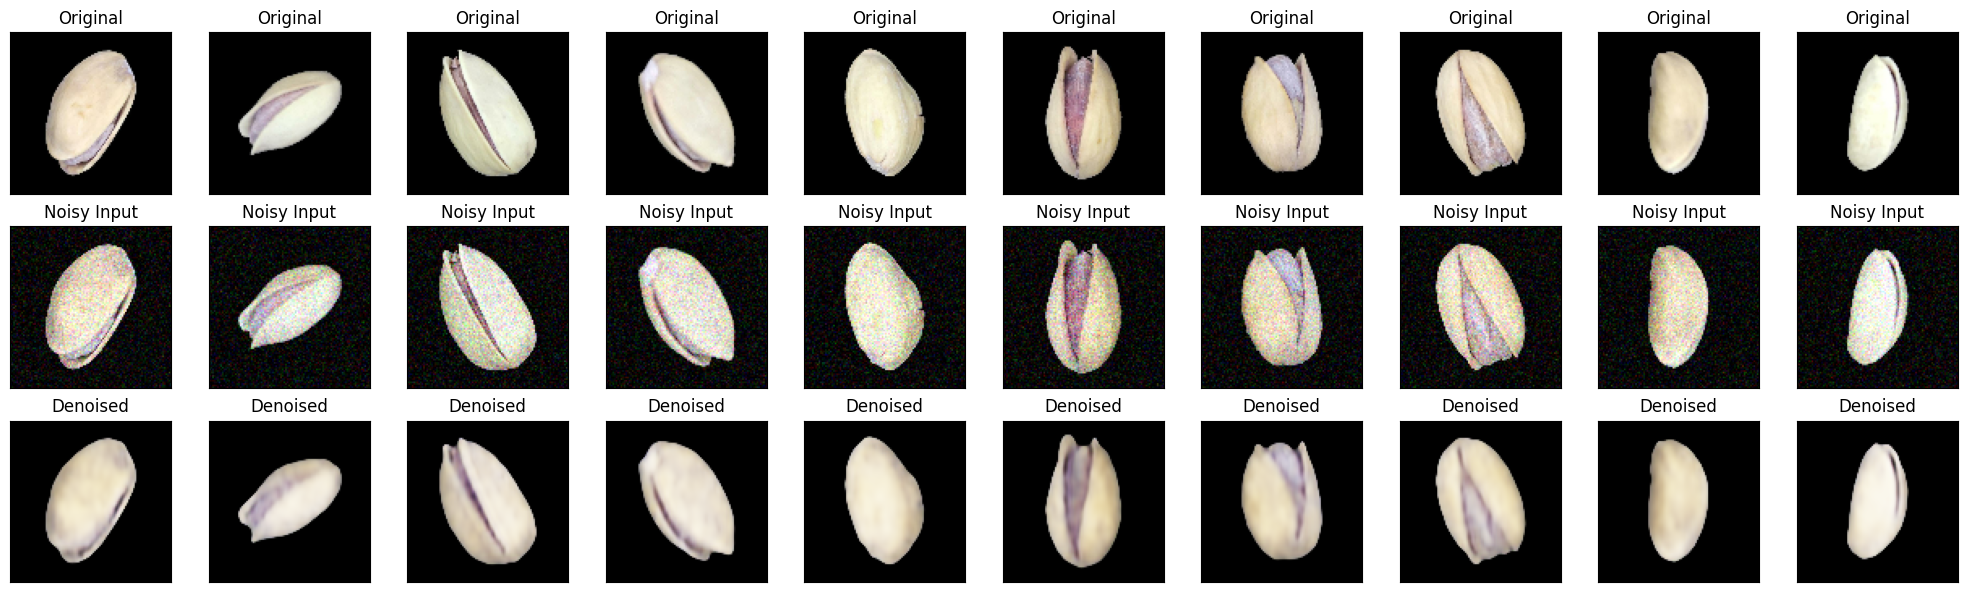

In [ ]:
denoised_images_tuned = tuned_autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 6))

for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy Input")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_images_tuned[i])
    plt.title("Denoised")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
denoised_baseline = autoencoder.predict(x_test_noisy)
denoised_manual = manual_autoencoder.predict(x_test_noisy)
denoised_tuned = tuned_autoencoder.predict(x_test_noisy)

ssim_baseline = tf.image.ssim(tf.convert_to_tensor(X_test), tf.convert_to_tensor(denoised_baseline), max_val=1.0)
ssim_manual = tf.image.ssim(tf.convert_to_tensor(X_test), tf.convert_to_tensor(denoised_manual), max_val=1.0)
ssim_tuned = tf.image.ssim(tf.convert_to_tensor(X_test), tf.convert_to_tensor(denoised_tuned), max_val=1.0)

avg_ssim_baseline = tf.reduce_mean(ssim_baseline).numpy()
avg_ssim_manual = tf.reduce_mean(ssim_manual).numpy()
avg_ssim_tuned = tf.reduce_mean(ssim_tuned).numpy()

print("\n--- Hasil Evaluasi SSIM ---")
print(f"SSIM Model Baseline: {avg_ssim_baseline:.4f}")
print(f"SSIM Model Modifikasi Manual: {avg_ssim_manual:.4f}")
print(f"SSIM Model Hasil Tuning: {avg_ssim_tuned:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 494ms/step


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step

--- Hasil Evaluasi SSIM ---
SSIM Model Baseline: 0.9421
SSIM Model Modifikasi Manual: 0.9520
SSIM Model Hasil Tuning: 0.9531


**PEMBAHASAN HASIL, KESIMPULAN, EVALUASI**

Dapat dilihat bahwa nilai SSIM yang dihasilkan sudah dapat dikatakan baik, kita bisa melihat nilai SSIM untuk model baseline di angka 0.9421, mpodif manual 0.9520, dan tuning 0.9531.

Namun disini kita melihat bahwa setelah perubahan yang kita buat, nilainya tidak berbeda jauh. dapat diasumsikan bahwa noise yang ditambahkan kemungkinan tidak cukup merusak struktur gambar sedari awal. sehingga model yang standar saja sudah menghasilkan hasil yang sangat bagus. Dan untuk mendapatkan hasil yang lebih bagus lagi, mungkin diperlukan augmentasi data untuk menambah variasi data atau arsitekturnya diubah lagi secara fundamental mungkin menggunakan U-net dengan skip connections untuk restorasi detail yang lebih halus


https://drive.google.com/file/d/1SMJAQr1lakG4U5xaj5HotomjwCPQwiFP/view?usp=sharing